<a href="https://colab.research.google.com/github/Yashu2699/Deep_learning/blob/main/Semantic_seg/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize

import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
np.random.seed(42)

width = 128
height = 128
channels = 3

train_path = "/content/drive/MyDrive/Colab Notebooks/deep learning /Object_Segmentation/data-science-bowl-2018/stage1_train/"
test_path = "/content/drive/MyDrive/Colab Notebooks/deep learning /Object_Segmentation/data-science-bowl-2018/stage1_test/"

train_ids = next(os.walk(train_path))[1]
test_ids = next(os.walk(test_path))[1]

In [32]:
X_train = np.zeros((len(train_ids), height, width, channels), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), height, width, 1), dtype=bool)

In [33]:
from sys import breakpointhook
for n, id in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = train_path + id
  img = imread(path + '/images/' + id + '.png')[:,:,:channels]
  img = resize(img, (height, width), mode='constant', preserve_range=True)
  X_train[n] = img

  mask = np.zeros((height, width, 1), dtype=bool)
  for mask_file in next(os.walk(path + '/masks/'))[2]:
    mask_ = imread(path + '/masks/' + mask_file)
    mask_ = np.expand_dims(resize(mask_, (height, width), mode='constant', preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)

  Y_train[n] = mask

100%|██████████| 625/625 [1:08:37<00:00,  6.59s/it]


In [34]:
X_test = np.zeros((len(test_ids), height, width, channels), dtype=np.uint8)

for n, id in tqdm(enumerate(test_ids), total=len(test_ids)):
  path = test_path + id
  img = imread(path + '/images/' + id + '.png')[:,:,:channels]
  img = resize(img, (height, width), mode='constant', preserve_range=True)

  X_test[n] = img

100%|██████████| 65/65 [00:33<00:00,  1.92it/s]


In [ ]:
Y_train

In [ ]:
image_x = random.randint(0, len(train_ids))

imshow(X_train[image_x])
plt.show()

imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [44]:
import keras

from keras.layers import Input, Lambda, concatenate
from keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [45]:
input = Input((height, width, channels))
s = Lambda(lambda x: x / 255)(input)

c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)
 
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

output = Conv2D(1, (1,1), activation='sigmoid')(c9)

In [46]:
model = tf.keras.Model(inputs=[input], outputs=[output])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

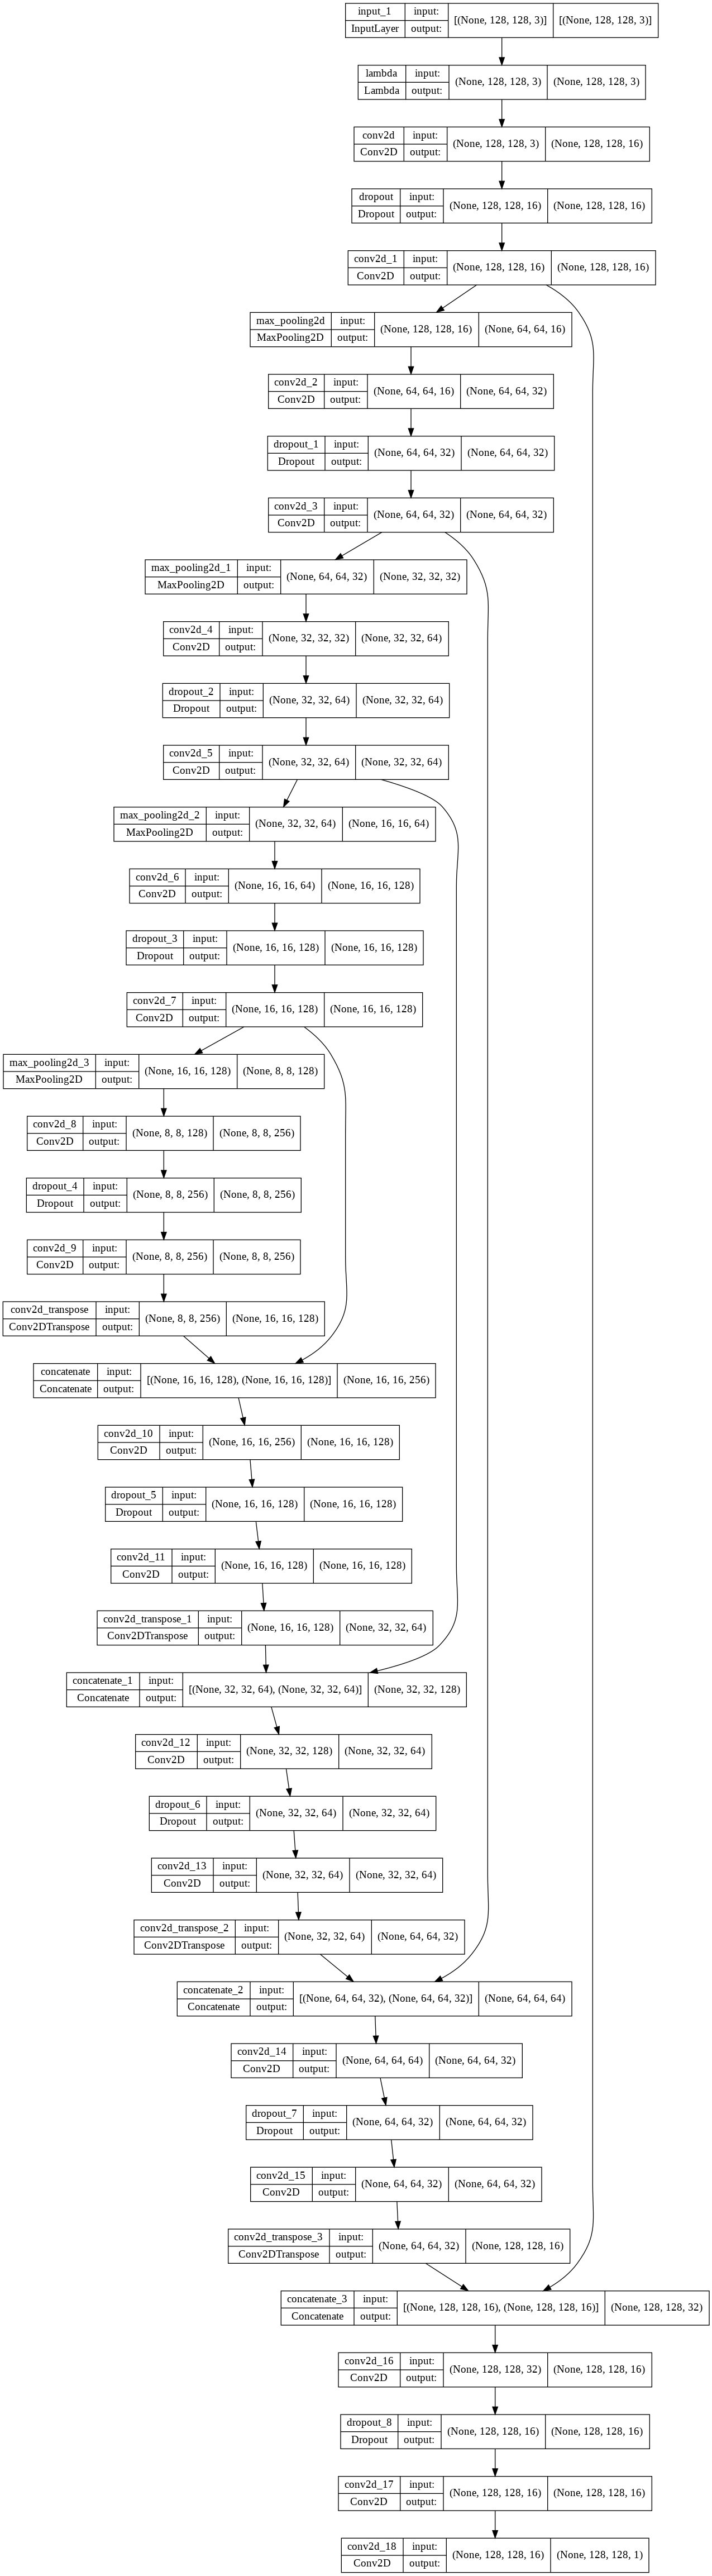

In [47]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='unet.png', show_shapes=True, show_layer_names=True)

In [48]:
checkpointer = ModelCheckpoint('unet.h5', verbose=1, save_best_only=True)
earlystopping = EarlyStopping(patience=3, monitor='val_loss')
tensorboard = TensorBoard(log_dir='logs')

callbacks = [checkpointer, earlystopping, tensorboard]

In [49]:
result = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
36/36 [==============================] - ETA: 0s - loss: 0.6389 - accuracy: 0.7942
Epoch 1: val_loss improved from inf to 0.52201, saving model to unet.h5
36/36 [==============================] - 101s 3s/step - loss: 0.6389 - accuracy: 0.7942 - val_loss: 0.5220 - val_accuracy: 0.7799
Epoch 2/25
36/36 [==============================] - ETA: 0s - loss: 0.3883 - accuracy: 0.8004
Epoch 2: val_loss improved from 0.52201 to 0.33951, saving model to unet.h5
36/36 [==============================] - 94s 3s/step - loss: 0.3883 - accuracy: 0.8004 - val_loss: 0.3395 - val_accuracy: 0.7808
Epoch 3/25
36/36 [==============================] - ETA: 0s - loss: 0.2658 - accuracy: 0.8692
Epoch 3: val_loss improved from 0.33951 to 0.22670, saving model to unet.h5
36/36 [==============================] - 95s 3s/step - loss: 0.2658 - accuracy: 0.8692 - val_loss: 0.2267 - val_accuracy: 0.9071
Epoch 4/25
36/36 [==============================] - ETA: 0s - loss: 0.2082 - accuracy: 0.9184
Epoch 4: val

In [50]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 2s 612ms/step


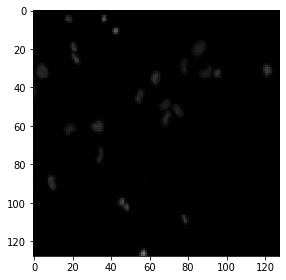

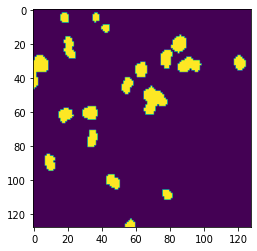

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


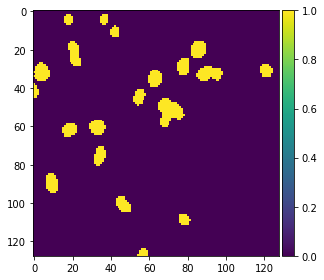

In [56]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

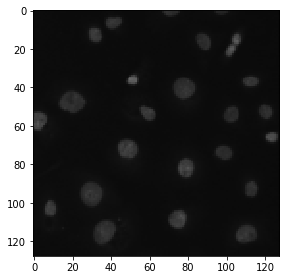

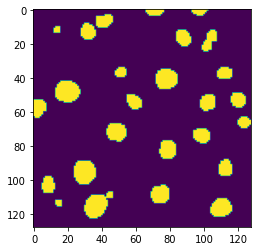

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


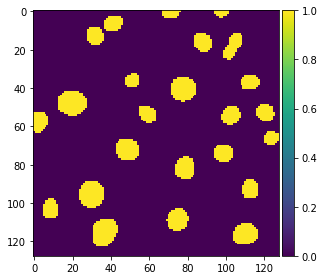

In [57]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
plt.imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()